In [1]:
!pipinstallopencv-python

/bin/bash: line 1: pipinstallopencv-python: command not found


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
from numpy import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

###Displaying top 5 examples from each class separated in mounted drive.

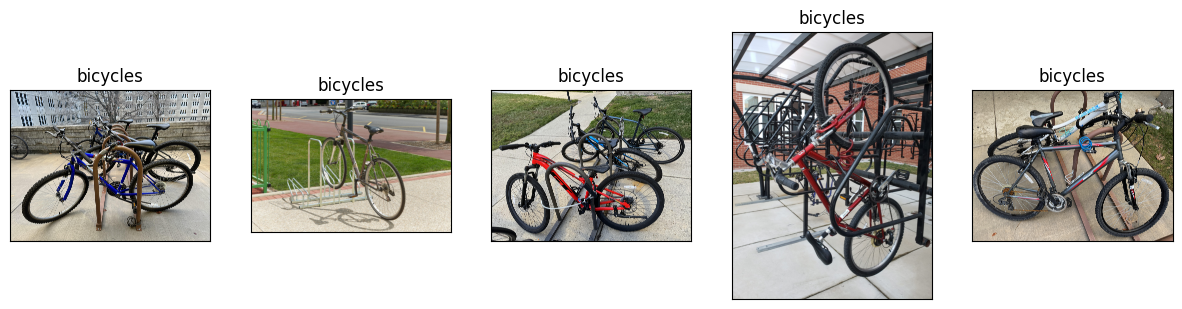

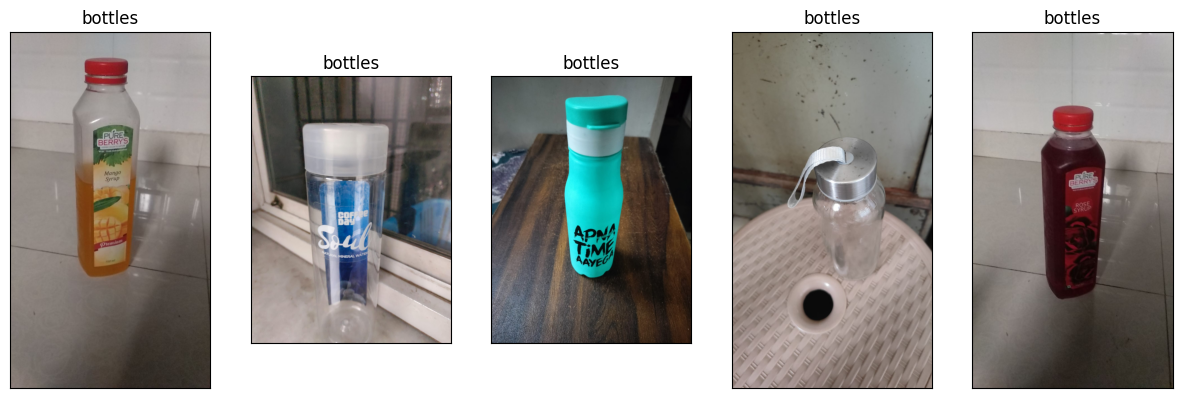

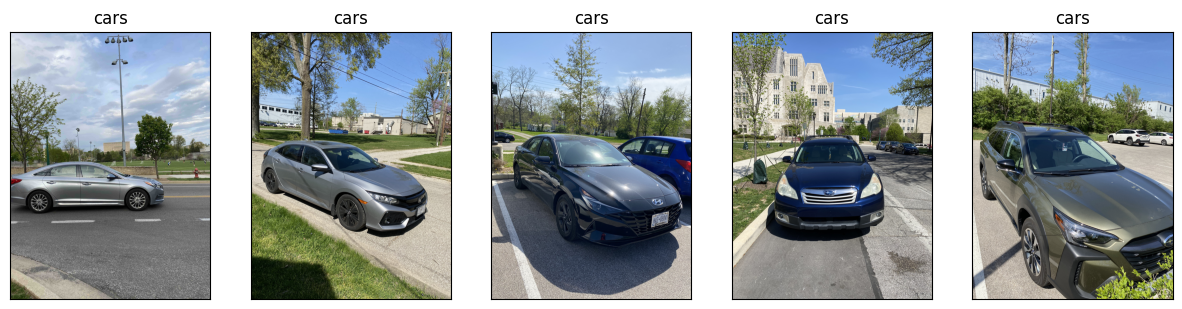

In [4]:
TRAIN_DATADIR = "/content/drive/MyDrive/AML_HW4/train"
TEST_DATADIR = "/content/drive/MyDrive/AML_HW4/test"
VALIDATION_DATADIR = "/content/drive/MyDrive/AML_HW4/validation"
CATEGORIES = ["bicycles","bottles","cars"]


num_examples = 5
for class_name in CATEGORIES:
  class_dir = os.path.join(TRAIN_DATADIR, class_name)
  images = os.listdir(class_dir)
  random.shuffle(images)
  fig, ax = plt.subplots(nrows=1, ncols=num_examples, figsize=(15, 5))
  for i in range(num_examples):
    image_name = images[i]
    image_path = os.path.join(class_dir, image_name)
    image = Image.open(image_path)
    ax[i].imshow(image)
    ax[i].set_title(class_name)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()


##Pipeline for Augmenting


We have performed resizing, scaling, flipping, rotate, shifting and zooming in with the help of
ImageDataGenerator.
We have just rescaled the test data and augmented+rescaled the training data.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

##Splitting the images into a training set, a validation set, and a test set.

As we see in the below images, we have kept the number of images above the required threshold as per
the assignment. In total we have kept 371 images split into 251 training, 60 validation and 60 test
images.

##Preprocessing of the data has also been performed to resize the images to 100 x 100

In [6]:
image_width = 100
image_height = 100
batch = 10

print("Training Dataset: ")
train_dataset = train_datagen.flow_from_directory(TRAIN_DATADIR,
                                                  target_size=(image_height, image_width),
                                                  batch_size=batch,
                                                  class_mode='categorical')
print("Validation Dataset: ")
validation_dataset = test_datagen.flow_from_directory(VALIDATION_DATADIR,
                                                      target_size=(image_height, image_width),
                                                      batch_size=batch,
                                                      class_mode='categorical')
print("Testing Dataset: ")
test_dataset = test_datagen.flow_from_directory(TEST_DATADIR,
                                                target_size=(image_height, image_width),
                                                batch_size=batch,
                                                class_mode='categorical')

Training Dataset: 
Found 251 images belonging to 3 classes.
Validation Dataset: 
Found 60 images belonging to 3 classes.
Testing Dataset: 
Found 60 images belonging to 3 classes.


##Training the pre‑trained model MobileNetV2.


We will be fine tuning the last few layers of MobileNetV2 trained on the weights of ImageNet database,
with our custom‑made dataset for performing this classification. The reason for choosing MobileNetV2
was that it provides a good balance between accuracy and efficiency, making it suitable for real‑time
applications on resource‑constrained environments for detecting objects.


In [9]:
base_model = keras.applications.MobileNetV2(input_shape=(image_height, image_width, 3),
                                            include_top=False,
                                            weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [11]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(CATEGORIES), activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
NUM_EPOCHS = 15
history = model.fit(train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/15
26/26 [==============================] - 369s 14s/step - loss: 0.8793 - accuracy: 0.7490 - val_loss: 0.0987 - val_accuracy: 0.9667
Epoch 2/15
26/26 [==============================] - 26s 1s/step - loss: 0.0798 - accuracy: 0.9681 - val_loss: 0.0757 - val_accuracy: 0.9833
Epoch 3/15
26/26 [==============================] - 27s 1s/step - loss: 0.0640 - accuracy: 0.9761 - val_loss: 0.0526 - val_accuracy: 0.9833
Epoch 4/15
26/26 [==============================] - 27s 1s/step - loss: 0.0388 - accuracy: 0.9841 - val_loss: 0.0322 - val_accuracy: 0.9833
Epoch 5/15
26/26 [==============================] - 27s 1s/step - loss: 0.0810 - accuracy: 0.9721 - val_loss: 0.0565 - val_accuracy: 0.9833
Epoch 6/15
26/26 [==============================] - 27s 1s/step - loss: 0.0303 - accuracy: 0.9841 - val_loss: 0.0436 - val_accuracy: 0.9667
Epoch 7/15
26/26 [==============================] - 25s 934ms/step - loss: 0.0283 - accuracy: 0.9841 - val_loss: 0.1274 - val_accuracy: 0.9833
Epoch 8/15
26/2

In [13]:
model.evaluate(test_dataset)

6/6 [==============================] - 57s 11s/step - loss: 2.7185e-04 - accuracy: 1.0000


[0.00027185268118046224, 1.0]

We get a testing accuracy of 100% & validation accuracy of 96.67% using pre-trained MobileNet model.
Training accuracy is continuously increasing as seen in the above
training and stops at 99.2%

Since the objects in the dataset are completely different from each other and have no similarity, the model is clearly able to differentiate between the images resulting in such high accuracy.

##Defining a generic function to show the correctly and incorrectly classified images

In [14]:
def showClassifications(model, test_dataset):
    test_images, test_labels = next(test_dataset)
    y_pred = model.predict(test_images)

    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    correct_indices = np.where(y_pred == y_true)[0]
    incorrect_indices = np.where(y_pred != y_true)[0]

    d1 = {0: "bicycles", 1: "bottles", 2: "cars"}

    print('Correctly classified images:')
    for i in range(5):
        index = correct_indices[i]
        plt.imshow(test_images[index])
        plt.title('True label: {}, Predicted label: {}'.format(d1[y_true[index]], d1[y_pred[index]]))
        plt.show()

    print('\n\nIncorrectly classified images:')
    for i in range(len(incorrect_indices)):
        index = incorrect_indices[i]
        plt.imshow(test_images[index])
        plt.title('True label: {}, Predicted label: {}'.format(d1[y_true[index]], d1[y_pred[index]]))
        plt.show()

1/1 [==============================] - 0s 25ms/step
Correctly classified images:


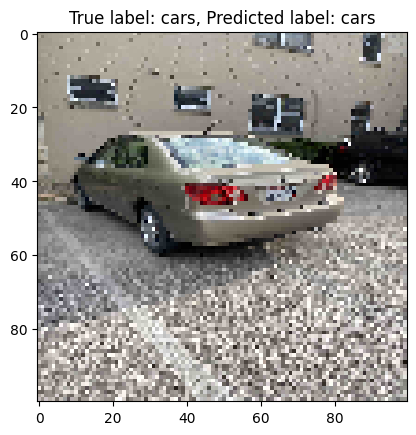

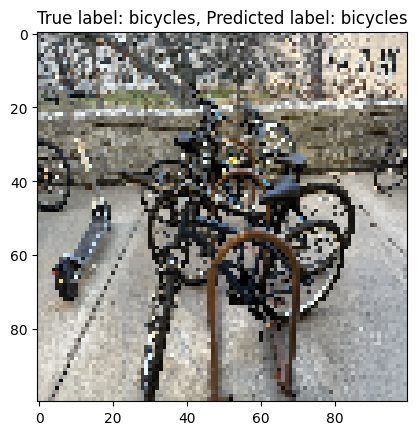

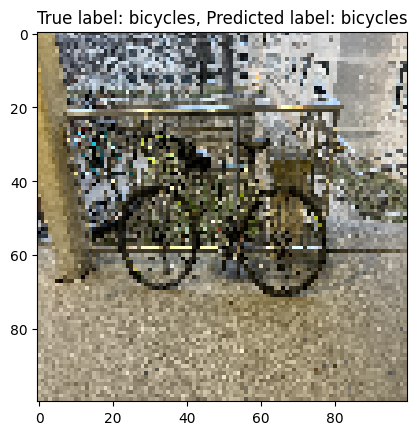

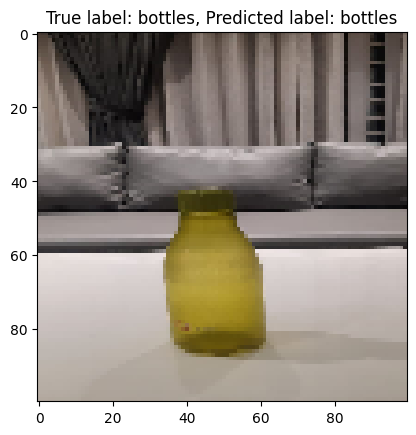

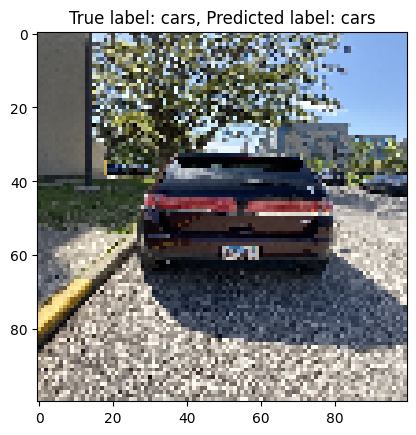



Incorrectly classified images:


In [16]:
showClassifications(model, test_dataset)

As the model was pretty robust showing 100% it is able to predict almost everything
correctly. Hence, when we are trying to plot the incorrectly & correctly classified
images, we are getting just 0 image in return.


#Training on a model from Scratch.

In [19]:
model_scratch = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_scratch.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NUM_EPOCHS = 10
history12 = model_scratch.fit(train_dataset,
                    epochs=NUM_EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
26/26 [==============================] - 30s 981ms/step - loss: 1.1054 - accuracy: 0.3147 - val_loss: 1.0245 - val_accuracy: 0.3833
Epoch 2/10
26/26 [==============================] - 29s 1s/step - loss: 0.9078 - accuracy: 0.5219 - val_loss: 0.7121 - val_accuracy: 0.6667
Epoch 3/10
26/26 [==============================] - 26s 988ms/step - loss: 0.7880 - accuracy: 0.6135 - val_loss: 0.7312 - val_accuracy: 0.6667
Epoch 4/10
26/26 [==============================] - 27s 1s/step - loss: 0.7710 - accuracy: 0.6972 - val_loss: 0.7899 - val_accuracy: 0.7000
Epoch 5/10
26/26 [==============================] - 25s 974ms/step - loss: 0.5621 - accuracy: 0.7968 - val_loss: 1.3196 - val_accuracy: 0.6667
Epoch 6/10
26/26 [==============================] - 26s 992ms/step - loss: 0.2849 - accuracy: 0.8964 - val_loss: 0.5824 - val_accuracy: 0.8333
Epoch 7/10
26/26 [==============================] - 27s 1s/step - loss: 0.4793 - accuracy: 0.8287 - val_loss: 0.3286 - val_accuracy: 0.9000
Epoch 8/

In [20]:
model_scratch.evaluate(test_dataset)

6/6 [==============================] - 4s 740ms/step - loss: 0.2127 - accuracy: 0.9000


[0.21274325251579285, 0.8999999761581421]

We get a testing accuracy of 89.99% & validation accuracy of 73.33% using our model. Training accuracy is fluctuating and stops at around 93.63% at the end
of 10th epoch. On the basis of these figures we can say that our model is not
overfitting the data.

1/1 [==============================] - 0s 69ms/step
Correctly classified images:


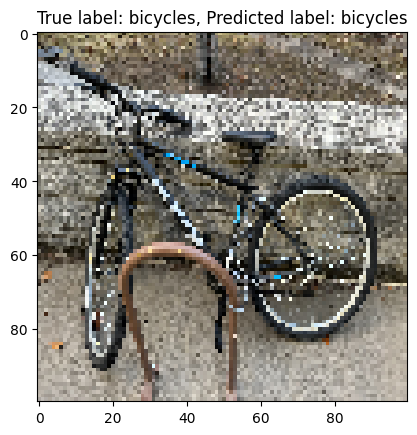

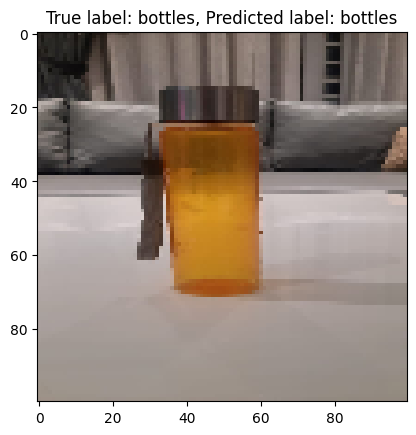

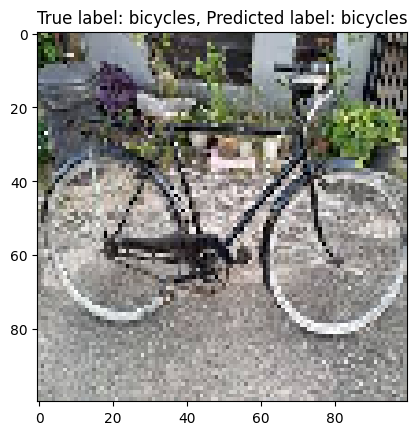

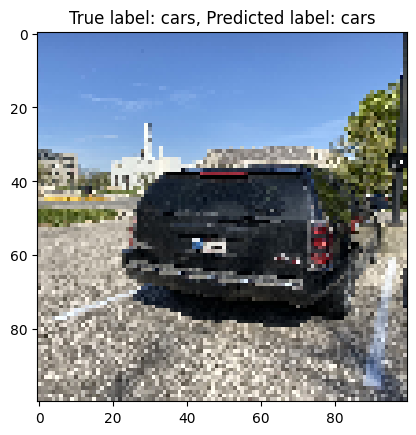

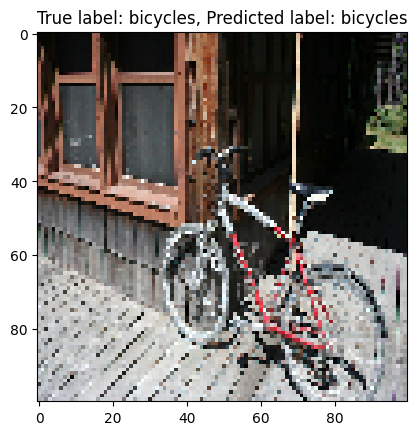



Incorrectly classified images:


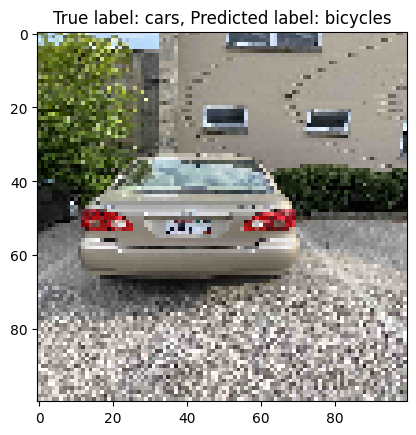

In [21]:
showClassifications(model_scratch, test_dataset)

From the above images, we see in the incorrectly classified images that the model is confused while distinguishing between cars and bicycles which may be because the cars, after being pixelated look like a bicycle. So we can infer that the model is performing correctly if not perfectly.

#CONCLUSION


We see a significant drop in the accuracy for the model trained from scratch as
compared to the pre‑trained model because the one built from scratch needs to learn
the geometry, shadows and multiple other factors which are already known to the
pretrained model when we import its weights. Another factor is the size of the input
dataset which is currently not very large, otherwise the model can learn and perform
much better.